In [110]:
import os
import pickle
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt, resample

import matplotlib.pyplot as plt

from snn.resonator import create_excitatory_inhibitory_resonator
from utils import copy_filter_hp_to_other_clock_frequency

# EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'
data_root = "../datasets/kaggle_data/signal/"

trial = 4
channels=['AccV', 'AccAP', 'AccAP']
channel = channels[0]

fs = 128

bands = {
    # '1': (1, 2),
    '2': (2, 3),
    '3': (3, 4),
    '4': (4, 5),
    '5': (5, 6),
    '6': (6, 7),
    '7': (7, 8),
    '8': (8, 9),
    '9': (9, 10),
    '10': (10, 11),
    '11': (11, 12),
    '12': (12, 13),
    '13': (13, 14),
    '14': (14, 15),
    '15': (15, 16),
}

In [132]:
# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)

def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AccV','AccML', 'AccPL']  # FP2 should really be AF4
    dat.columns = labels


    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = 2, 40
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i,c in enumerate(labels)})

    # Z-transform each column
    #dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


def plot_spectrogram(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=fs, cmap='jet')
    print(Sxx)
    # plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    if show:
        plt.show()
    return Sxx


def fft_spectogram2bins(Sxx, window):
    print(len(Sxx[0]))
    bins_count = len(Sxx[0])//window + 1
    bin_sxx = np.zeros((14, bins_count))

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(bands.values()):
        for i in range(bins_count):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    return bin_sxx

def plot_bins(Sxx, duration, labels, annotate=True, rotate_annotate=False, show=True):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0, duration, 0, len(Sxx)]
               )

    ax.set_yticks(np.arange(len(Sxx)), labels=labels)
    if annotate:
        bin_size = duration / len(Sxx[0])
        rotation_degree = 90 * rotate_annotate
        for i in range(len(Sxx)):
            for j in range(len(Sxx[i])):
                text = ax.text(j * bin_size + bin_size*.5, i + .5,  f'{Sxx[i, j]:.4f}',
                               rotation=rotation_degree,
                               ha="center", va="center", color="white")

    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    if show:
        plt.show()


def array_to_bins(array, N):
    bins = np.array_split(array, N)
    bin_sums = np.array([np.sum(bin) for bin in bins], dtype=np.int64)
    return bin_sums


def spikes_to_bands(spikes_spectrogram):
    bands_spectrogram = np.zeros((19, spikes_spectrogram.shape[1]))
    for i in range(19):
        bands_spectrogram[i] = np.sum(spikes_spectrogram[i:i+5], axis=0) / (768 + i*768)
    return bands_spectrogram

In [133]:
trial = "0b2b9bc455.csv"
trial_path = os.path.join(data_root,trial)
trial_data = pd.read_csv(trial_path, index_col=0, compression='gzip')


[[3.72921714e+01 3.72641973e+01 3.72664885e+01 ... 3.85070422e+01
  4.17585907e+01 4.87827599e+01]
 [1.88670203e+01 1.88549989e+01 1.88783041e+01 ... 1.96136758e+01
  1.94585791e+01 2.56890127e+01]
 [1.17793354e-04 1.54771732e-04 4.84145946e-04 ... 5.07675789e-02
  9.20292018e-02 2.98386071e-02]
 ...
 [1.71360458e-10 7.78427582e-08 2.76105724e-05 ... 5.38816411e-06
  4.11975967e-06 6.80886458e-08]
 [5.96162582e-08 2.00939516e-07 2.51451574e-05 ... 2.48299738e-06
  5.86759409e-06 3.56776383e-07]
 [3.41099615e-08 2.03011314e-08 1.02835520e-05 ... 1.84348658e-08
  3.77837505e-06 2.05180951e-07]]
30


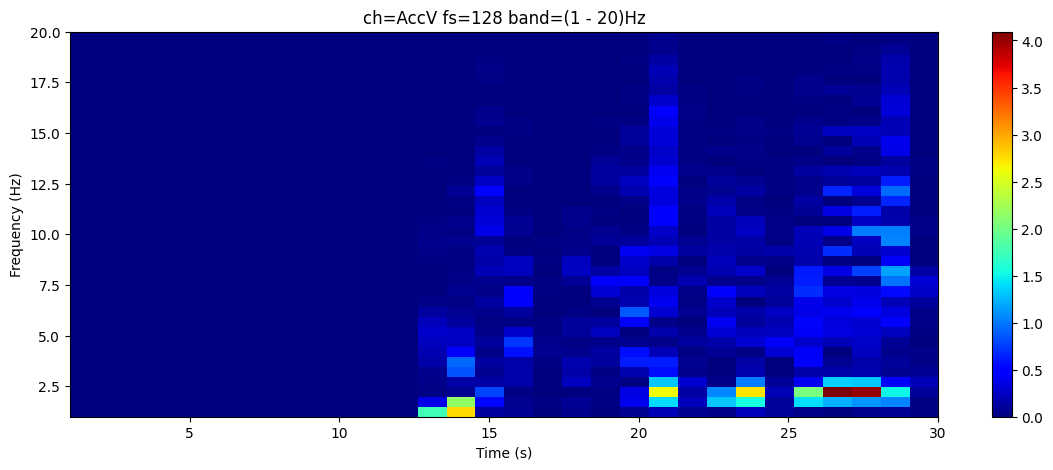

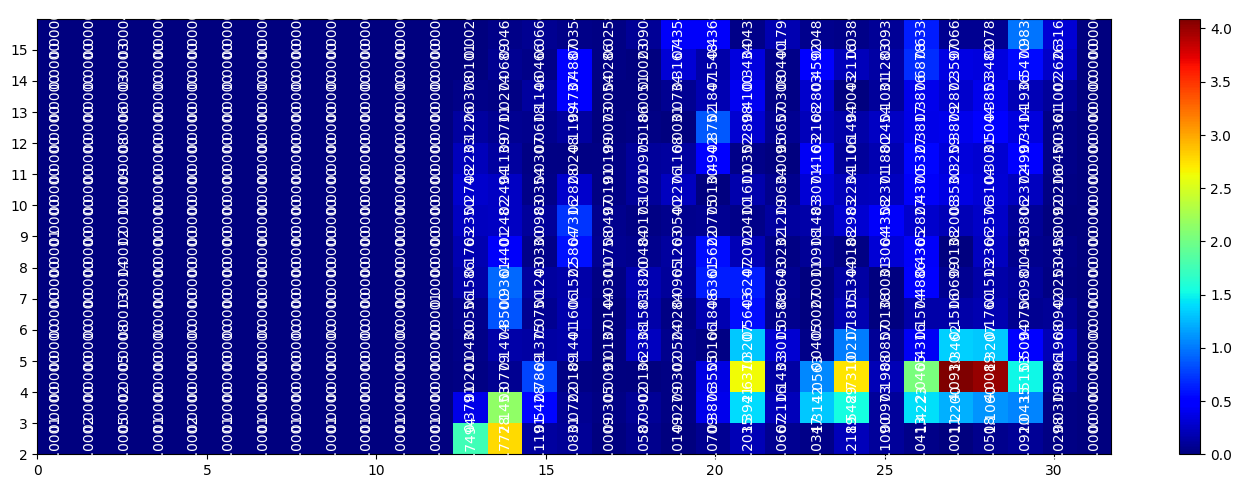

In [134]:
fft_spectogram = plot_spectrogram(trial_data[channel], channel_name=channel, fs=fs, fmin=1, fmax=20, show=False)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
plot_bins(fft_bin_spectogram, len(trial_data[channel])/fs, bands.keys(), annotate=True, rotate_annotate=True)

In [114]:
time_start_s = int(1500/fs)
time_end_s = int(len(trial_data[channel])/fs)
sliced_data = trial_data[channel][time_start_s*fs:time_end_s*fs]

Text(0.5, 1.0, 'Slice data on Time domain')

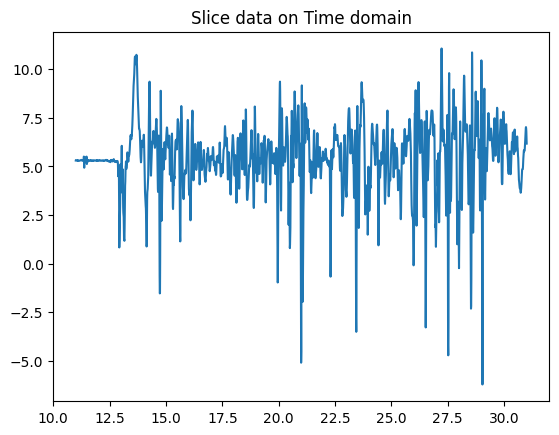

In [115]:
plt.plot(np.linspace(time_start_s, time_end_s, len(sliced_data)) , sliced_data)
plt.title('Slice data on Time domain')

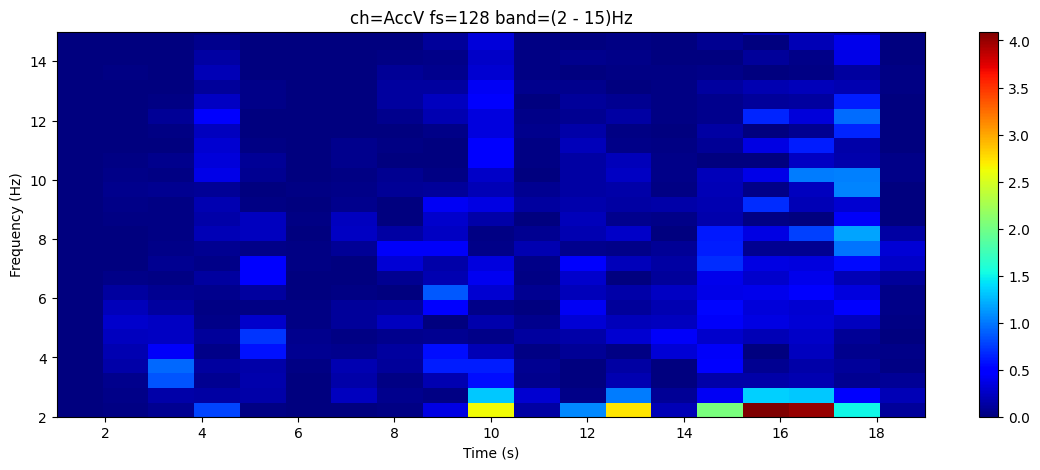

19


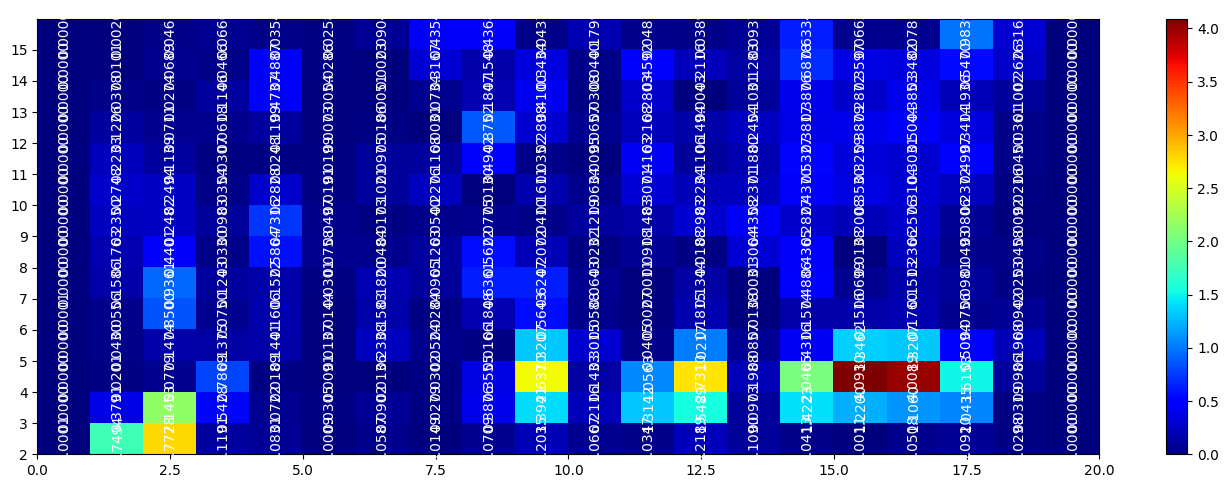

In [116]:
sliced_data = trial_data[channel][time_start_s*fs:time_end_s*fs]

fft_spectogram = plot_spectrogram(sliced_data, channel_name=channel, fs=fs, fmin=2, fmax=15, show=True)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
plot_bins(fft_bin_spectogram, len(sliced_data)/fs, bands.keys(), rotate_annotate=True)

In [117]:
sliced_data /= np.max(np.abs(sliced_data))

In [118]:
clk_resonators = {
    15360: ['0.6', '1.0', '1.39', '1.64', '1.93'],
    30720: ['2.36','2.78','3.28','3.86'],
    61440: ['4.0','4.72','5.56','6.56','7.72'],
    122880: ['8.0','9.44','11.12','13.12', '15.44'],
    # 15360: ['0000.6', '0001.0', '001.39', '001.64', '001.93'],
    # 30720: ['002.36', '002.78', '003.28', '003.86'],
    # 61440: ['0004.0', '004.72', '005.56', '006.56'],
    # 122880: ['0008.0', '009.44', '011.12', '013.12','015.44']
}

In [119]:
from tqdm import tqdm

output = {}
with tqdm(total=20) as pbar:
    for clk_i, (clk_freq, list_of_f0) in enumerate(clk_resonators.items()):
        sliced_data_resampled = resample_signal(clk_freq, fs, sliced_data)
        output[clk_freq] = []
        for f_i, f0 in enumerate(list_of_f0):
            resonator = create_excitatory_inhibitory_resonator(
                freq0=f0,
                clk_freq=clk_freq)
            resonator.log_out_spikes(-1)
            output_neuron = resonator.layers_neurons[-1].neurons[-1]
            # append 5 seconds of zero to make the resonator converge.
            resonator.input_full_data(np.zeros(clk_freq * 5))
            resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output[clk_freq].append(output_neuron.out_spikes[clk_freq * 5:output_neuron.index])
            pbar.update(1)

with open('sliced_data_output.pickle', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)

 95%|█████████▌| 19/20 [04:13<00:13, 13.35s/it]


In [120]:
import pickle

with open('sliced_data_output.pickle', 'rb') as f:
    output = pickle.load(f)

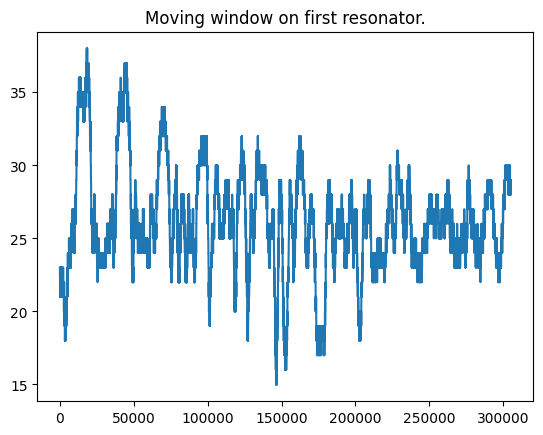

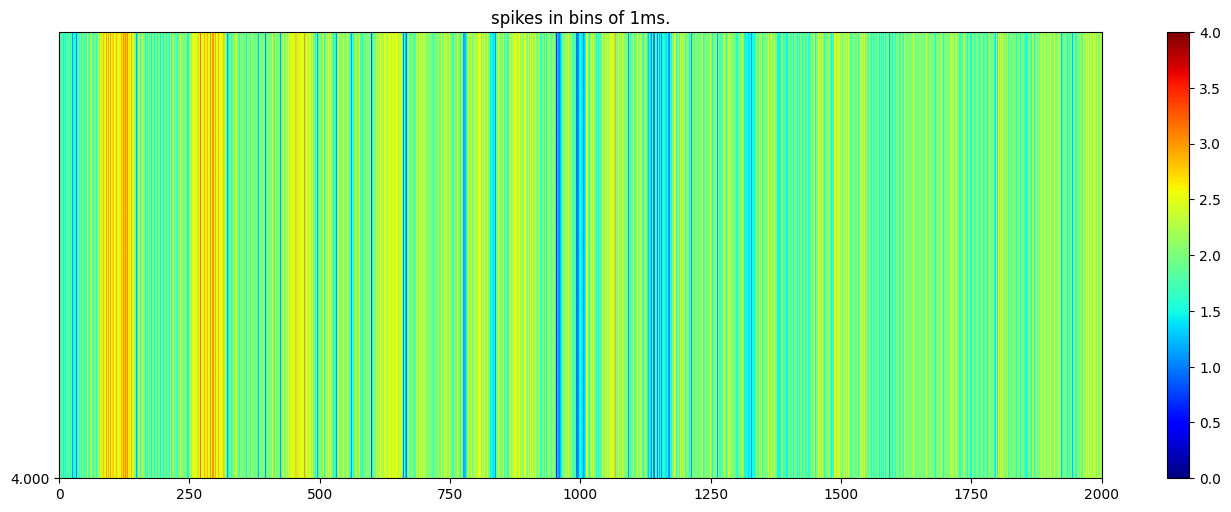

In [121]:
clk_freq = next(iter(output.keys()))

y_spikes = output[clk_freq][0]
y_spikes = np.convolve(y_spikes, np.ones(2000, dtype=int), 'valid')
plt.plot(y_spikes)
plt.title('Moving window on first resonator.')
plt.show()

y_spikes = output[clk_freq][0]
spikes_spectrogram = np.zeros((1, len(y_spikes)//clk_freq*100))
spikes_spectrogram[0] = array_to_bins(y_spikes, spikes_spectrogram.shape[1])
plot_bins(spikes_spectrogram, spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False)
plt.title('spikes in bins of 1ms.')
plt.show()

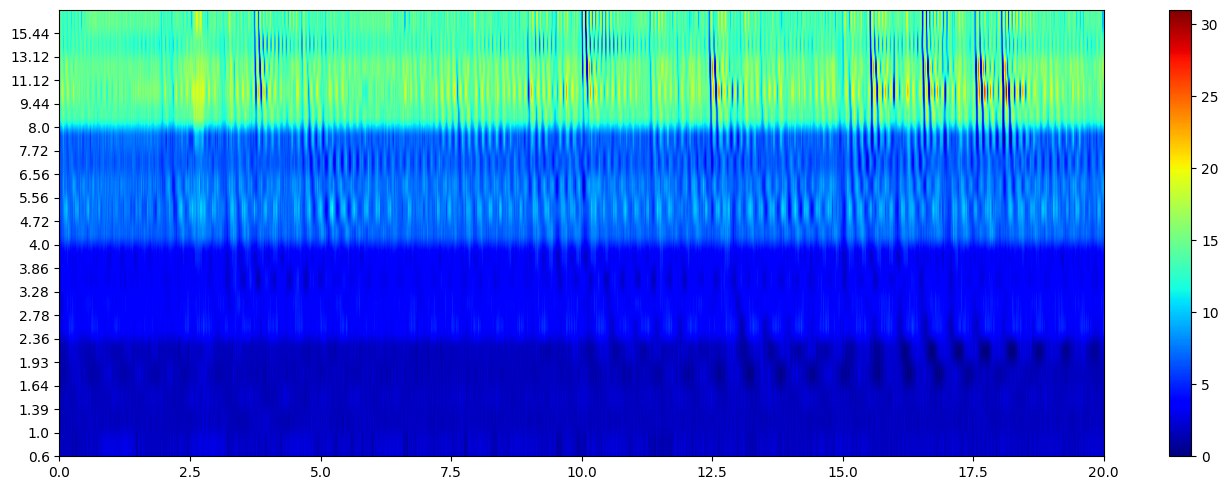

In [122]:
spikes_array = sum(output.values(), start=[])
clk_freq, values = next(iter(output.items()))
num_of_bins = len(values[0]) // clk_freq * 100

# axis 0 - resonators
# axis 1 - number of bins ( I set to 1ms)
spikes_spectrogram = np.zeros((len(spikes_array), num_of_bins))

for i, spikes in enumerate(spikes_array):
    spikes_spectrogram[i] = array_to_bins(spikes, spikes_spectrogram.shape[1])

plot_bins(spikes_spectrogram, len(sliced_data)/fs, labels=sum(clk_resonators.values(), []), annotate=False)

In [123]:
print(spikes_spectrogram.shape)

(19, 2000)


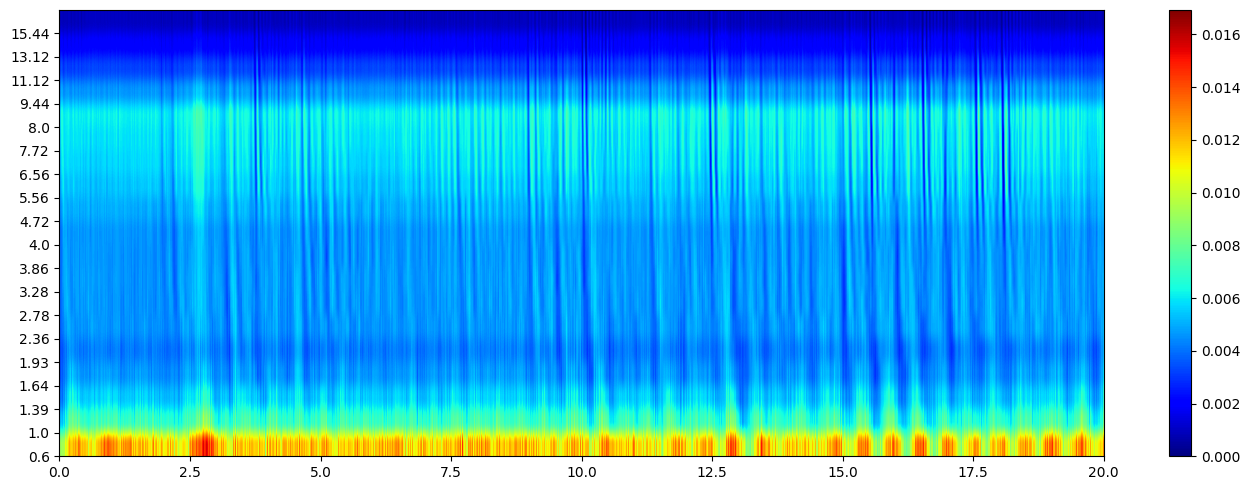

In [124]:
spikes_bands_spectrogram = spikes_to_bands(spikes_spectrogram)
res_labels = ['0.6', '1.0', '1.39', '1.64', '1.93', '2.36','2.78','3.28','3.86','4.0','4.72','5.56','6.56','7.72', '8.0','9.44','11.12','13.12', '15.44']
    # 15360: ['0000.6', '0001.0', '001.39', '001.64', '001.93'],
    # 30720: ['002.36', '002.78', '003.28', '003.86'],
    # 61440: ['0004.0', '004.72', '005.56', '006.56'],
    # 122880: ['0008.0', '009.44', '011.12', '013.12','015.44']

plot_bins(spikes_bands_spectrogram, len(sliced_data)/fs, res_labels, annotate=False)

In [125]:
import numpy as np

# Create a sample NumPy array
arr = np.array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1])
# Use numpy.where() to get the indices of all the 1s
indices = np.where(arr == 1)[0]

# Print the indices
print(indices)

[ 1  3  4  6 10 11]


In [126]:
class ResonatorSpikes:

    def __init__(self, clk_freq, resonator_freq, spikes_path):
        self.clk_freq = clk_freq
        self.resonator_freq = resonator_freq
        self.events = None
        self._load_spikes(spikes_path)

    def _load_spikes(self, spikes_path):
        spikes_array = np.load(spikes_path)['spikes']
        # if the file is already events based spikes
        if np.max(spikes_array) > 1:
            self.events = spikes_array
        else:
            self.events = np.where(spikes_array == 1)[0]


class ChannelSpikes:

    def __init__(self, base_folder, trial, channel_name):
        self.trial = trial
        self.channel_name = channel_name
        self.resonators_output = {}
        self.load_resonators_output(base_folder)

    def load_resonators_output(self, base_folder):
        channel_folder = f'{base_folder}/{self.trial}/{self.channel_name}'
        for clk_freq in os.listdir(channel_folder):
            clk_folder = f'{channel_folder}/{clk_freq}'
            for spikes in os.listdir(clk_folder):
                resonator_freq = spikes[:-4]
                self.resonators_output[resonator_freq] = ResonatorSpikes(int(clk_freq), float(resonator_freq), f'{clk_folder}/{spikes}')


In [128]:
import numpy as np

def moving_window_sum(indices, window_size):
    result = np.zeros_like(indices)  # Initialize result array

    cum_sum = np.cumsum(np.ones_like(indices))  # Calculate cumulative sum of ones

    # Calculate the window start and end indices
    window_starts = np.maximum(0, indices - window_size // 2)
    window_ends = np.minimum(len(indices), indices + window_size // 2 + 1)

    # Perform moving window sum using numpy.ufunc.reduceat()
    result = np.add.reduceat(cum_sum, window_ends) - np.add.reduceat(cum_sum, window_starts)

    return result

In [129]:
arr = np.random.randint(0, 10, 10000)
arr[arr != 1] = 0
indices = np.where(arr == 1)[0]
len(indices), len(arr)

(963, 10000)

In [130]:
import numpy as np

def reduce_to_bins(indices, window):
    N = indices[-1]//window + 1
    print(N)
    bins = np.zeros(N, dtype=int)  # Initialize an array of N bins with all zeros
    unique_indices, counts = np.unique(np.array(indices) // window, return_counts=True)
    bins[unique_indices] = counts

    return bins.tolist()

def naive_reduce_to_bins(data, window):
    N = len(data) // window
    bins = [0] * N  # Initialize an array of N bins with all zeros
    print(N)
    for i, value in enumerate(data):
        if value == 1:
            bins[i // window] += 1  # Increment the count in the corresponding bin

    return bins

100
100


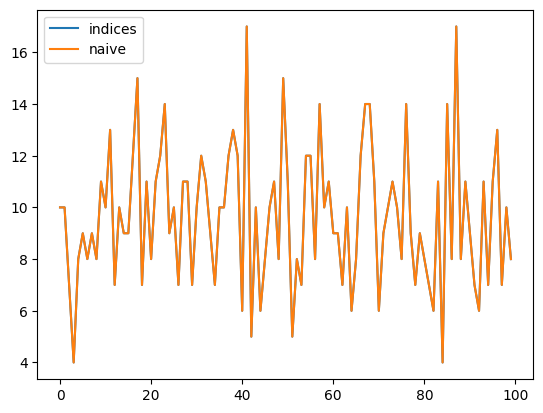

In [131]:
ind_mw = reduce_to_bins(indices, 100)
plt.plot(ind_mw, label='indices')
plt.plot(naive_reduce_to_bins(arr, 100), label='naive')
plt.legend()
# window_starts = np.maximum(0, indices - (100 // 2))
# window_starts